In [6]:
import numpy as np
import torch
import sys
from utils import *
from matplotlib import pyplot as plt
import torch.nn as nn
import time
from numba import cuda
from tqdm import tqdm, trange
import os
import pyroc
import pandas as pd
import gc
from IPython.display import clear_output
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="6"  
device = torch.device("cuda:0")
dtype = torch.float32
torch.manual_seed(42)
np.random.seed(42)

In [7]:

H = 300
out= 100
L = 1
class DN(torch.nn.Module):
    def __init__(self, H=300, out=100):
        super(DN, self).__init__()
        self.restored = False
        self.model = torch.nn.Sequential(
            torch.nn.Linear(28, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, out, bias=True),
        )
    def forward(self, input):
        output = self.model(input)
        return output

class another_DN(torch.nn.Module):
    def __init__(self, H=300, out=100):
        super(another_DN, self).__init__()
        self.restored = False
        self.model = torch.nn.Sequential(
            torch.nn.Linear(28, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, 28, bias=True),
        )
    def forward(self, input):
        output = self.model(input) + input
        return output

class Classifier(torch.nn.Module):
    def __init__(self, H=300, layers = 5, tanh=False):
        super(Classifier, self).__init__()
        self.restored = False
        self.model = torch.nn.Sequential(
            torch.nn.Linear(28, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, 1, bias=True),
            torch.nn.Sigmoid(),
        )
        if layers == 6:
            self.model = torch.nn.Sequential(
                torch.nn.Linear(28, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, 1, bias=True),
                torch.nn.Sigmoid(),
            )
        if tanh:
            self.model = torch.nn.Sequential(
                torch.nn.Linear(28, H, bias=True),
                torch.nn.Tanh(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.Tanh(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.Tanh(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.Tanh(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.Tanh(),
                torch.nn.Linear(H, 1, bias=True),
                torch.nn.Sigmoid()
            )
    def forward(self, input):
        output = self.model(input)
        return output

In [8]:
dataset = np.load('HIGGS.npy')
dataset_P = dataset[dataset[:,0]==0][:, 1:] # background (5829122, 28)
dataset_Q = dataset[dataset[:,0]==1][:, 1:] # signal     (5170877, 28)
dataset_P = MatConvert(dataset_P, device=device, dtype=dtype)
dataset_Q = MatConvert(dataset_Q, device=device, dtype=dtype)

In [9]:
cc = (1/11*np.sqrt(1100)) / (1/10.5*np.sqrt(1050))
cc

0.9770084209183946

# 画 p-n


In [16]:
ns = np.array([1300000, 1000000, 700000, 400000, 200000, 50000])
ps_L = np.zeros(ns.shape[0])
ps_G = np.zeros(ns.shape[0])
ps_O = np.zeros(ns.shape[0])
ps_S = np.zeros(ns.shape[0])
ps_L_std = np.zeros(ns.shape[0])
ps_G_std = np.zeros(ns.shape[0])
ps_O_std = np.zeros(ns.shape[0])
ps_S_std = np.zeros(ns.shape[0])
ps_L_thres = np.zeros(ns.shape[0])
ps_G_thres = np.zeros(ns.shape[0])
ps_O_thres = np.zeros(ns.shape[0])
ps_S_thres = np.zeros(ns.shape[0])
ps_L_thres_std = np.zeros(ns.shape[0])
ps_G_thres_std = np.zeros(ns.shape[0])
ps_O_thres_std = np.zeros(ns.shape[0])
ps_S_thres_std = np.zeros(ns.shape[0])
ps_S_thres_5 = np.zeros(ns.shape[0])
ps_S_thres_5_std = np.zeros(ns.shape[0])

for i in range(6):
    n = ns[i]

    temp = np.load('./Mix/%d_soft.npy'%n)
    temp = temp[temp!=np.inf]
    ps_L[i] = np.mean(temp)
    ps_L_std[i] = np.std(temp)
    temp = np.load('./Mix/%d_hard.npy'%n)
    ps_L_thres[i] = np.mean(temp)
    ps_L_thres_std[i] = np.std(temp)

    temp = np.load('./Fea_Gau/%d_soft.npy'%n)
    temp = temp[temp!=np.inf]
    ps_G[i] = np.mean(temp)
    ps_G_std[i] = np.std(temp)
    temp = np.load('./Fea_Gau/%d_hard.npy'%n)
    ps_G_thres[i] = np.mean(temp)
    ps_G_thres_std[i] = np.std(temp)

    temp = np.load('./Gaussian/%d_soft.npy'%n)
    temp = temp[temp!=np.inf]
    ps_O[i] = np.mean(temp)
    ps_O_std[i] = np.std(temp)
    temp = np.load('./Gaussian/%d_hard.npy'%n)
    ps_O_thres[i] = np.mean(temp)
    ps_O_thres_std[i] = np.std(temp)

    temp = np.load('./Scheffe/%d_soft.npy'%n)
    temp = temp[temp!=np.inf]
    ps_S[i] = np.mean(temp)
    ps_S_std[i] = np.std(temp)
    temp = np.load('./Scheffe/%d_hard.npy'%n)
    ps_S_thres[i] = np.mean(temp)
    ps_S_thres_std[i] = np.std(temp)

    temp = np.load('./Scheffe/%d_05.npy'%n)
    temp = temp[temp!=np.inf]
    ps_S_thres_5[i] = np.mean(temp)
    ps_S_thres_5_std[i] = np.std(temp)


/math/home/eruisun/software/anaconda/envs/LFI/lib/python3.9/site-packages/numpy/core/_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


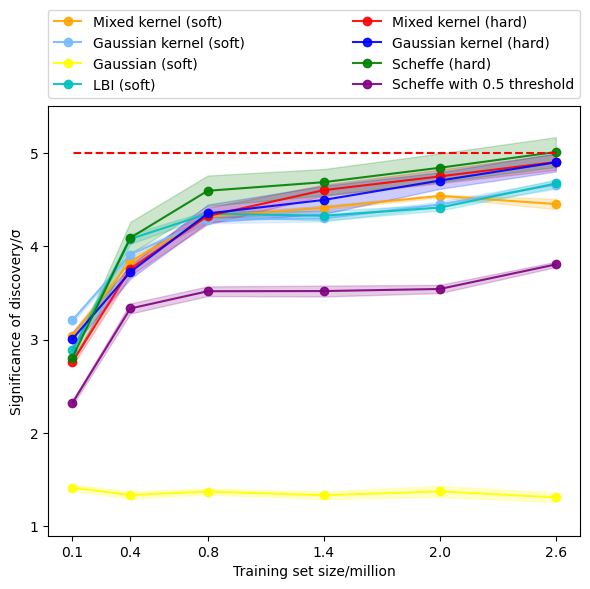

: 

In [19]:
# for ps in [ps_L, ps_G, ps_O, ps_S]:
#     ps = ps /(1/11*np.sqrt(1100)) * (1/10.5*np.sqrt(1050))
ns = np.array([1300000, 1000000, 700000, 400000, 200000, 50000])
fig = plt.figure(figsize=(6, 6))
# 直接求和
plt.plot(ns, ps_L, label='Mixed kernel (soft)', marker='o', alpha=0.9, color='orange')
plt.fill_between(ns, ps_L-ps_L_std, ps_L+ps_L_std, alpha=0.2, color='orange')

plt.plot(ns, ps_G, label='Gaussian kernel (soft)', marker='o', alpha=0.9, color='xkcd:sky blue')
plt.fill_between(ns, ps_G-ps_G_std, ps_G+ps_G_std, alpha=0.2, color='xkcd:sky blue')

plt.plot(ns, ps_O, label='Gaussian (soft)', marker='o', alpha=0.9, color='yellow')
plt.fill_between(ns, ps_O-ps_O_std, ps_O+ps_O_std, alpha=0.2, color='yellow')

plt.plot(ns, ps_S, label='LBI (soft)', marker='o', alpha=0.9, color='c')
plt.fill_between(ns, ps_S-ps_S_std, ps_S+ps_S_std, alpha=0.2, color='c')

# 加上threshold
plt.plot(ns, ps_L_thres, label='Mixed kernel (hard)', marker='o', alpha=0.9, color='red')
plt.fill_between(ns, ps_L_thres-ps_L_thres_std, ps_L_thres+ps_L_thres_std, alpha=0.2, color='red')

plt.plot(ns, ps_G_thres, label='Gaussian kernel (hard)', marker='o', alpha=0.9, color='blue')
plt.fill_between(ns, ps_G_thres-ps_G_thres_std, ps_G_thres+ps_G_thres_std, alpha=0.2, color='blue')
#plt.plot(ns, ps_O_thres, label='Gaussian (hard)', marker='o', alpha=0.9, color='pink')
plt.plot(ns, ps_S_thres, label='Scheffe (hard)', marker='o', alpha=0.9, color='green')
plt.fill_between(ns, ps_S_thres-ps_S_thres_std, ps_S_thres+ps_S_thres_std, alpha=0.2, color='green')

plt.plot(ns, ps_S_thres_5, label='Scheffe with 0.5 threshold', marker='o', alpha=0.9, color='purple')
plt.fill_between(ns, ps_S_thres_5-ps_S_thres_5_std, ps_S_thres_5+ps_S_thres_5_std, alpha=0.2, color='purple')

plt.legend(bbox_to_anchor =(1, 1))
plt.xlabel('Training set size/million')
plt.xticks(ns, ns*2/10**6)
plt.ylabel('Significance of discovery/σ')
plt.ylim(0.9, 5.5)
#plt.title('Test on 1000 backgrounds and 100 signals')
#plt.tight_layout()
plt.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2)

#plt.yticks([cc, 2*cc, 3*cc, 4*cc, 5*cc, 5], [1, 2, 3, 4 ,5, '5σ'])
plt.plot(ns, 5*np.ones(ns.shape[0]), 'r--')
plt.tight_layout()
plt.savefig('./paper/p-n.pdf')
plt.savefig('Significance of discovery.png')
plt.show()



In [12]:
ps_L_thres

array([4.9023335 , 4.7479553 , 4.60087549, 4.32437277, 3.75861766,
       2.7589235 ])